Trip Purpose Estimation

# Loading packages

In [45]:
import pandas as pd
#import geopandas as gpd
#import shapely
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
# import eli5
# from eli5.sklearn import PermutationImportance
import rfpimp
from sklearn.feature_selection import SelectFromModel

# oversampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

# Loading data

The data should contain the nearby POI information from the Google Place API. 

`Preprocessing is needed`

Consider using the POI types from the paper by Emagun et al.

In [2]:
X_16 = pd.read_csv('../../Data/model_inputs/gdf_2016_X.csv')
y_16 = pd.read_csv('../../Data/model_inputs/gdf_2016_y.csv')
X_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_X.csv')
y_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_y.csv')

In [4]:
X_all = pd.concat([X_16, X_17],axis=0)
y_all = pd.concat([y_16, y_17],axis=0)

The encoding of **purpose** and **mode** is as follows. Note that the trips of home and work have been removed.

- purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
- mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

In [5]:
X_all.columns

Index(['id_trip', 'mode', 'duration', 'distance_m', 'weekday', 'precip',
       'temp', 'morning', 'midday', 'afternoon', 'evening', 'midnight',
       'startx', 'starty', 'endx', 'endy'],
      dtype='object')

The meaning of X variables is shown below.

| Variable | Meaning | Unit |
|:-------- | :-------- | :---- |
| id_trip | Unique ID | NA |
| mode | Trip mode | {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5} |
| duration | Trip duration | Second |
| distance_m | Trip distance (which distance??) (TK) | Metre |
| weekday | Whether this trip occurs in a weekday (Monday to Friday) | {1:True, 0:False} |
| precip | Precipitation on this date (date or hour?) (TK) | TBC |
| temp | Temperature on this date (date or hour?) (TK) | Celcius |
| morning | Whether this trip occurs in the morning time 0600-1059 | {1:True, 0:False} |
| afternoon | Whether this trip occurs in the afternoon time 1100-1359 | {1:True, 0:False} |
| evening | Whether this trip occurs in the evening time 1700-2159 | {1:True, 0:False} |
| midnight | Whether this trip occurs in the midnight time 2200-0559 | {1:True, 0:False} |
| startx | The x coordinate of the starting point in the TBC reference system | Metre |
| starty | The y coordinate of the starting point in the TBC reference system | Metre |
| endx | The x coordinate of the ending point in the TBC reference system | Metre |
| endy | The y coordinate of the ending point in the TBC reference system | Metre |

In [10]:
# replace False and True with 0 and 1, respectively
X_all = X_all.replace({True: 1, False: 0})

In [11]:
X_all.head()

,id_trip,mode,duration,distance_m,weekday,precip,temp,morning,midday,afternoon,evening,midnight,startx,starty,endx,endy
0,1889461,1,447,1843.264582,1,0.000134,25.844886,0,0,0,1,0,7.632056e+06,1.247584e+06,7.630298e+06,1.248129e+06
1,2071991,3,844,2761.792383,1,0.001427,24.930720,0,0,0,1,0,7.628002e+06,1.247761e+06,7.626230e+06,1.247150e+06
2,1667922,3,1211,1068.301088,1,0.001429,21.769356,0,0,0,0,1,7.628518e+06,1.246293e+06,7.629432e+06,1.246198e+06
3,2072003,0,1266,1394.114250,0,0.000000,16.639258,1,0,0,0,0,7.628223e+06,1.247461e+06,7.628197e+06,1.246306e+06
4,2072007,0,603,552.535139,0,0.000000,21.759996,0,1,0,0,0,7.629631e+06,1.245856e+06,7.630013e+06,1.245629e+06


In [6]:
y_all.columns

Index(['purpose'], dtype='object')

In [7]:
print('The size of each trip purpose:')
y_all['purpose'].value_counts()

The size of each trip purpose:


0    15479
2    13405
1     8504
4     4437
3     3852
5     3076
Name: purpose, dtype: int64

# Variable settings and algorithms

 There are four settings of variables
 - Basic (without nearby trip purposes or Google nearby Places)
 - Basic and nearby trips
 - Basic and Google POIs
 - Baisc and nearby trips and Google POIs 
 
 
 There are two algorithms:
 - Random Forest
 - Nested Logit
 
 
 Based on exhaustive combinations of settings and algorithms, eight models will be trained.
 
 In this notebook, we will compare four random forest models. Each model will be tuned using GridSearchCV.
 
 The basic variables include the following:
 - 'mode'
 - 'duration'
 - 'distance_m'
 - 'weekday'
 - 'precip'
 - 'temp'
 - 'morning' 
 - 'midday' 
 - 'afternoon'
 - 'evening'
 - 'midnight'
 
 
 There is no need to normalise continuous variables before using RF.

## Utility functions

### A function that runs a standard random forest model

In [78]:
def run_rf(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=None):
    """
        Run a random forest classification model
    """
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    clf.fit(X_train, y_train)
    score = clf.score(X_test,y_test)
    preds = clf.predict(X_test)
    #print("Random Forest Classifcation accuracy:", score)
    return clf, score, preds

### A function to compute the proportions of nearby trip purposes in the training data (TK)

In [ ]:
def compute_nearby_purposes(y_train, X_train, X_test):
    """
        Augment the training and testing data with the proportions of nearby trip purposes in the training data.
        :param y_train: (dataframe) the trip purpose of the training data, which is used to compute proportions of nearby trip purposes. Should contain a column of 'purpose'
        :param X_train: (dataframe) the predictor variables of the training data. Should contain three columns of 'id', endx' and 'endy'.
        :param X_test: (dataframe) the predictor variables of the testing data. Should contain two columns of 'id', 'endx' and 'endy'.
        :return: (list) [X_train_aug, X_test_aug]. X_train_aug and X_test_aug are the X_train and X_test augmented with extra columns, respectively. The new columns are ['p_nearby_0', 'p_nearby_1', 'p_nearby_2', 'p_nearby_3', 'p_nearby_4', 'p_nearby_5']
        Note: when selecting the trips close to a trip in the training data, remember to exclude this trip itself using the 'id' column.
    """

# Basic RF

In [12]:
basic_variable = ['mode', 'duration', 'distance_m', 'weekday', 'precip',
       'temp', 'morning', 'midday', 'afternoon', 'evening', 'midnight']

# extract basic variables
X_all_basic_variable = X_all[basic_variable]

In [27]:
print(X_all_basic_variable.shape)
print(y_all.shape)
print(np.ravel(y_all).shape)

(48753, 11)
(48753, 1)
(48753,)


In [60]:
# split training testing data
rd_state = 42

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_all_basic_variable, np.ravel(y_all), stratify=y_all, random_state=rd_state)

In [41]:
# run the random forest algorithm on this dataset
rf_clf, rf_accuracy_rest, rf_pred_test = run_rf(X_train, X_test, y_train, y_test)

In [42]:
# print results
print("Accuracy on training data: ", rf_clf.score(X_train, y_train))
print("Accuracy on testing data: ", rf_accuracy_rest)

Accuracy on training data:  1.0
Accuracy on testing data:  0.4018377225367134


The prediciton accuracy on the training and testing data is 1.0 and 0.402, respectively, indicating that the model is overfitting.

In [43]:
print(sklearn.metrics.classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.46      0.55      0.50      3870
           1       0.33      0.29      0.30      2126
           2       0.41      0.45      0.43      3352
           3       0.20      0.10      0.13       963
           4       0.42      0.38      0.40      1109
           5       0.30      0.16      0.21       769

    accuracy                           0.40     12189
   macro avg       0.35      0.32      0.33     12189
weighted avg       0.39      0.40      0.39     12189



It is seen that the F1 is the highest for the trips of type 0 and 2, and the lowest for type 3 and 5.

## Feature importance

In [48]:
# n_samples is set as 5000 by default. 
# Setting n_samples as -1 means entire validation set
# the score metric used is accuracy, aka number of records that are correctly predicted
imp = rfpimp.importances(rf_clf, X_test, y_test, n_samples=-1)

In [49]:
print(imp)

            Importance
Feature               
mode          0.067356
temp          0.031504
weekday       0.019936
distance_m    0.019034
midnight      0.017557
duration      0.008696
midday        0.004430
precip        0.002625
morning      -0.002297
afternoon    -0.006317
evening      -0.006645


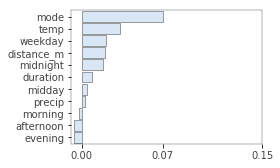

In [50]:
viz = rfpimp.plot_importances(imp)
viz.view()

It can be seen that the most important variables are:

- mode
- temp
- weekday
- distance_m
- midnight
- duration

## Model tuning

The hyperparameter of **n_estimators** will be tuned using *GridSearchCV*.

In [62]:
# testing on different n_estimators
list_n_estimators = [10, 50, 100, 200]

# by default n_estimator in random forest is 100
parameters = {'n_estimators': list_n_estimators}

# use the default 5-fold cross validation. 
# About CV: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
# In all other cases, KFold is used.
gscv_rfc = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), parameters)
gscv_rfc.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(gscv_rfc.best_params_)
print()
print("Grid scores on development set:")
print()
means = gscv_rfc.cv_results_['mean_test_score']
stds = gscv_rfc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gscv_rfc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full evaluation set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gscv_rfc.predict(X_test)
print(sklearn.metrics.classification_report(y_true, y_pred))


Best parameters set found on development set:

{'n_estimators': 200}

Grid scores on development set:

0.370 (+/-0.009) for {'n_estimators': 10}
0.389 (+/-0.012) for {'n_estimators': 50}
0.391 (+/-0.007) for {'n_estimators': 100}
0.392 (+/-0.007) for {'n_estimators': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.46      0.55      0.50      3870
           1       0.32      0.29      0.30      2126
           2       0.41      0.46      0.43      3352
           3       0.21      0.10      0.13       963
           4       0.42      0.38      0.40      1109
           5       0.28      0.16      0.20       769

    accuracy                           0.40     12189
   macro avg       0.35      0.32      0.33     12189
weighted avg       0.39      0.40      0.39     12189



In [64]:
# testing on different max_depth

# by default n_estimator in random forest is 100
parameters = {'max_depth': [10, 20, 50, 100]}

# use the default 5-fold cross validation. 
# About CV: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
# In all other cases, KFold is used.
gscv_rfc = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), parameters)
gscv_rfc.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(gscv_rfc.best_params_)
print()
print("Grid scores on development set:")
print()
means = gscv_rfc.cv_results_['mean_test_score']
stds = gscv_rfc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gscv_rfc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full evaluation set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gscv_rfc.predict(X_test)
print(sklearn.metrics.classification_report(y_true, y_pred))


Best parameters set found on development set:

{'max_depth': 10}

Grid scores on development set:

0.435 (+/-0.006) for {'max_depth': 10}
0.404 (+/-0.011) for {'max_depth': 20}
0.391 (+/-0.010) for {'max_depth': 50}
0.390 (+/-0.008) for {'max_depth': 100}

Detailed classification report:

The model is trained on the full evaluation set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.48      0.64      0.55      3870
           1       0.37      0.26      0.30      2126
           2       0.43      0.56      0.49      3352
           3       0.34      0.01      0.03       963
           4       0.48      0.38      0.43      1109
           5       0.55      0.15      0.23       769

    accuracy                           0.45     12189
   macro avg       0.44      0.33      0.34     12189
weighted avg       0.44      0.45      0.42     12189



In [65]:
# testing n_estimators and max_depth

# by default n_estimator in random forest is 100
parameters = {'max_depth': [10, 20, 50, 100], 'n_estimators':[10, 50, 100, 200]}

# use the default 5-fold cross validation. 
# About CV: For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
# In all other cases, KFold is used.
gscv_rfc = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestClassifier(), parameters)
gscv_rfc.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(gscv_rfc.best_params_)
print()
print("Grid scores on development set:")
print()
means = gscv_rfc.cv_results_['mean_test_score']
stds = gscv_rfc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gscv_rfc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full evaluation set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gscv_rfc.predict(X_test)
print(sklearn.metrics.classification_report(y_true, y_pred))

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200}

Grid scores on development set:

0.430 (+/-0.012) for {'max_depth': 10, 'n_estimators': 10}
0.432 (+/-0.004) for {'max_depth': 10, 'n_estimators': 50}
0.433 (+/-0.006) for {'max_depth': 10, 'n_estimators': 100}
0.435 (+/-0.006) for {'max_depth': 10, 'n_estimators': 200}
0.382 (+/-0.005) for {'max_depth': 20, 'n_estimators': 10}
0.401 (+/-0.009) for {'max_depth': 20, 'n_estimators': 50}
0.404 (+/-0.009) for {'max_depth': 20, 'n_estimators': 100}
0.405 (+/-0.009) for {'max_depth': 20, 'n_estimators': 200}
0.374 (+/-0.012) for {'max_depth': 50, 'n_estimators': 10}
0.390 (+/-0.008) for {'max_depth': 50, 'n_estimators': 50}
0.391 (+/-0.013) for {'max_depth': 50, 'n_estimators': 100}
0.392 (+/-0.006) for {'max_depth': 50, 'n_estimators': 200}
0.374 (+/-0.012) for {'max_depth': 100, 'n_estimators': 10}
0.387 (+/-0.010) for {'max_depth': 100, 'n_estimators': 50}
0.392 (+/-0.006) for {'max_depth': 100, 'n_est

The best hyperparameter found is **{'max_depth': 10, 'n_estimators': 200}**.

## Oversampling

In [66]:
X_train.columns

Index(['mode', 'duration', 'distance_m', 'weekday', 'precip', 'temp',
       'morning', 'midday', 'afternoon', 'evening', 'midnight'],
      dtype='object')

In [70]:
# define categorical variables
list_categorical_var = ['mode', 'weekday', 'morning', 'midday', 'afternoon', 'evening', 'midnight']
mark_cateogrical_var = [e in list_categorical_var for e in X_train.columns]
rd_state = 42

sm = SMOTENC(random_state=rd_state, categorical_features=mark_cateogrical_var)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [77]:
# check number of trip purposes in y_train
print("Number per trip purpose in y_train")
print(pd.Series(y_train).value_counts())
print("Number per trip purpose in y_train_res")
print(pd.Series(y_train_res).value_counts())
# check number of trip purposes in y_train_res

Number per trip purpose in y_train
0    11609
2    10053
1     6378
4     3328
3     2889
5     2307
dtype: int64
Number per trip purpose in y_train_res
5    11609
4    11609
3    11609
2    11609
1    11609
0    11609
dtype: int64


In [81]:
# compare the model using resampled data and 
rf_res, rf_res_accuracy_test, rf_res_pred_test = run_rf(X_train_res, X_test, y_train_res, y_test)
# print results
print("Accuracy on training data: ", rf_clf.score(X_train_res, y_train_res))
print("Accuracy on testing data: ", rf_res_accuracy_test)

Accuracy on training data:  0.731673701438539
Accuracy on testing data:  0.3783739437197473


The encoding of **purpose** and **mode** is as follows. Note that the trips of home and work have been removed.

- purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
- mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

In [82]:
print(sklearn.metrics.classification_report(y_test, rf_res_pred_test))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47      3870
           1       0.31      0.29      0.30      2126
           2       0.41      0.40      0.41      3352
           3       0.17      0.16      0.16       963
           4       0.35      0.44      0.39      1109
           5       0.24      0.25      0.24       769

    accuracy                           0.38     12189
   macro avg       0.33      0.33      0.33     12189
weighted avg       0.38      0.38      0.38     12189



In [83]:
print(sklearn.metrics.classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.46      0.55      0.50      3870
           1       0.33      0.29      0.30      2126
           2       0.41      0.45      0.43      3352
           3       0.20      0.10      0.13       963
           4       0.42      0.38      0.40      1109
           5       0.30      0.16      0.21       769

    accuracy                           0.40     12189
   macro avg       0.35      0.32      0.33     12189
weighted avg       0.39      0.40      0.39     12189



The oversampling doesn't lead to increase on the prediction accuracy. More predictor variables are needed for this task.

# Nearby trip RF

# POI_RF